In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits

import glob

# Holy shit it worked.

from lsst.sims.photUtils import Sed, Bandpass
import os

In [2]:
# Grab the current directory
cwd = os.getcwd()
# just one dir to start
directory = os.path.join(cwd, 'ckm05')
filepath = glob.glob(os.path.join(directory,'*.fits'))

In [3]:
# 
hdul = fits.open(filepath[-11])
# The header says what the 
header = hdul[0].header.copy()
spec_table = hdul[1].data.copy()
hdul.close()

In [4]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
DATE    = '2007-01-09T16:25:07' / Date FITS file was generated                  
IRAF-TLM= '11:25:19 (09/01/2007)' / Time of last modification                   
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 2002-02-22                     
FILENAME= 'ckm05_7250.fits'    / name of file                                   
NEXTEND =                    1 / number of extensions in file                   
TEFF    =                 7250                                                  
LOG_Z   =                 -0

(1000, 10000)

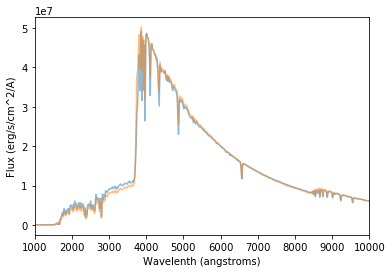

In [5]:
# Let's see what a few of them look like
plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=0.5)
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=.5)
# Always always keep track of units!
plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000])

In [6]:
# OK, those look like stellar spectra I can believe in.

In [7]:
# LSST standard is nm rather than Ang. I think I did this right.
my_sed = Sed(wavelen=spec_table['WAVELENGTH']/10., flambda=spec_table['g15']*10)

In [8]:
# now to read in an LSST bandpass 
band_dir = os.getenv("LSST_THROUGHPUTS_BASELINE")
filterlist =['u', 'g', 'r', 'i', 'z','y']
bps = []
for filtername in filterlist:
    tempB = Bandpass()
    tempB.readThroughput(os.path.join(band_dir, 'filter_'+filtername+'.dat'))
    bps.append(tempB)


In [9]:
bps

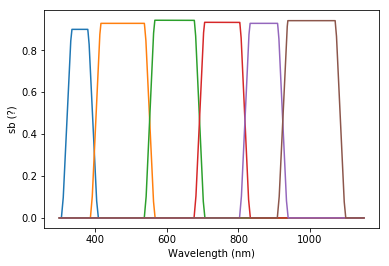

In [10]:
# Let's plot a few bandpass objects to make sure they look right
for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)')

In [11]:
for filtername,bp in zip(filterlist, bps):
    print(filtername, my_sed.calcMag(bp))

u -38.363286414
g -39.5932780266
r -39.5241955821
i -39.4106749041
z -39.3887605585
y -39.3510774412


In [12]:
# OK, that looks scary (because the sun only has an apparent mag of -27), but we never said 
#what distance the stars are at. So we can just add a constant to all the mags and it's fine.


Some good next steps:
* grab the narrow band filter throughputs from that survey, and figure out how to read them into bandpass objects
* Once we have all the filters and the stellar spectra, time to build a giant array! Each row would have star Teff, logg, metallicity, and then magnitudes in each LSST filter and narrowband filter. Can save the whole thing as a numpy zip file for easy reloading